# Execução do modelo
_Modelo rodando com dados de teste_

---

## Sumário

1. **Importação de bibliotecas**
2. **Carregamento das bases**
3. **Preparação dos dados**
    - 3.1. Exibição dos metadados
    - 3.2. Preparação dos dados
    - 3.3. Transformação das features das bases
4. **Executando o modelo**
    - 4.1. Carregando o melhor modelo
    - 4.2. Carregando as variáveis mais importantes
    - 4.3. Gerando as probabilidades e previsões nas bases
    - 4.4. Análise das probabilidades e previsões
5. **Análise do modelo e impacto no negócio**      

<br>

---

<br>

## 1. Importação de bibliotecas

In [2]:
# Importação de pacotes e definição de parâmetros globais

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import joblib

from pathlib import Path
from sklearn.preprocessing import StandardScaler, LabelEncoder


from matplotlib.colors import LinearSegmentedColormap
from pathlib import Path
from scipy.stats import ks_2samp
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, f1_score, auc, roc_curve, roc_auc_score, 
                             confusion_matrix, precision_recall_curve, precision_score, 
                             classification_report, recall_score, average_precision_score,
                             confusion_matrix)


In [3]:
# Configurações para exibição de dados no Jupyter Notebook

# Configurar para exibir todas as colunas do Dataframe
pd.set_option('display.max_columns', None)

# Configurar para exibir o conteúdo completo das colunas
pd.set_option('display.max_colwidth', None)

# Configurar a supressão de mensagens de aviso durante a execução
warnings.filterwarnings('ignore')

# Configurar o estilo do Seaborn
sns.set_theme(style='whitegrid')

## 2. Carregamento das bases

In [4]:
# Efetuando a limpeza da memória antes do carregamento dos dados

print(f'\nQuantidade de objetos removidos da memória: {gc.collect()}')


Quantidade de objetos removidos da memória: 0


In [ ]:
# Caminho base
base_path = Path('dados/dados_transformados_parquet/')

# Mapeamento nome_variavel: nome_arquivo
files = {
    'df_train': 'df_train.parquet',
    'df_val': 'df_val.parquet',
    'df_test': 'df_test.parquet'
}

# Carrega os DataFrames no dicionário
temp_dfs = {}
for var_name, file_name in files.items():
    try:
        temp_dfs[var_name] = pd.read_parquet(base_path / file_name)
    except Exception as e:
        print(f'Erro ao carregar {file_name}: {e}')

# Atribui às variáveis explicitamente
df_train, df_val, df_test = [temp_dfs[name] for name in ['df_train', 'df_val', 'df_test']]

## 3. Preparação dos dados

### 3.1. Exibição dos metadados

In [6]:
# Exibindo da volumetria dos dados

print('\nVOLUMETRIA')
for name, df in temp_dfs.items():
    print(f'\n{name}')
    print('-' * 45)
    print(f'Quantidade de linhas (registros):  {df.shape[0]:,}')
    print(f'Quantidade de colunas (variáveis): {df.shape[1]:,}')


VOLUMETRIA

df_train
---------------------------------------------
Quantidade de linhas (registros):  3,566,068
Quantidade de colunas (variáveis): 157

df_val
---------------------------------------------
Quantidade de linhas (registros):  891,518
Quantidade de colunas (variáveis): 157

df_test
---------------------------------------------
Quantidade de linhas (registros):  2,194,300
Quantidade de colunas (variáveis): 157


In [7]:
# Função para geração de um dataframe de metadados

def generate_metadata(dataframe):
    '''
    Gera um DataFrame contendo metadados das colunas do DataFrame fornecido.

    :param dataframe: DataFrame
        DataFrame para o qual os metadados serão gerados.
    :return: DataFrame
        DataFrame contendo os metadados.
    '''
    metadata = pd.DataFrame({
        'Variável': dataframe.columns,
        'Tipo': dataframe.dtypes,
        'Qtde de nulos': dataframe.isnull().sum(),
        '% de nulos': round((dataframe.isnull().sum() / len(dataframe)) * 100, 2),
        'Cardinalidade': dataframe.nunique(),
    }).sort_values(by='Qtde de nulos', ascending=False).reset_index(drop=True)

    return metadata

In [8]:
# Exibe todas as linhas temporariamente

with pd.option_context('display.max_rows', None):
    display(generate_metadata(df_test))

,Variável,Tipo,Qtde de nulos,% de nulos,Cardinalidade
0,transaction_id,float64,2194300,100.00,0
1,is_fraud,object,2194300,100.00,0
2,errors,object,2159694,98.42,20
3,card_std_last_1h,float64,2101247,95.76,40391
4,card_std_last_2h,float64,2071929,94.42,49496
5,client_std_last_1h,float64,2052961,93.56,53301
6,card_std_last_4h,float64,2023446,92.21,63020
7,client_std_last_2h,float64,1992546,90.81,69461
8,card_std_last_8h,float64,1944976,88.64,84634
9,client_std_last_4h,float64,1893979,86.31,97242


In [9]:
# Base utilizada no teste do modelo

print('\nDATAFRAME: df_test_full')
df_test.head()


DATAFRAME: df_test_full


,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,id_card,client_id_card,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web,id_client,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,code,description,transaction_id,is_fraud,hour,day,month,year,quarter,day_of_year,weekday,weekend,period_of_day,time_diff_transaction,high_risk_period,proportion_high_risk_period,mean_amount_by_client,flag_above_mean_amount,time_diff_client_card,age_group,years_acct_open,debt_to_income,monthly_income,amount_income_ratio,credit_score_category,flag_risky_chip_use,flag_no_chip_darkweb,center_lat,center_lon,distance_from_center,is_online_transaction,merchant_category_diversity,state_diversity_per_client,online_transaction_ratio,merchant_transaction_count,merchant_id_is_new,merchant_transaction_ratio,client_unique_merchants_count,most_common_mcc,mcc_transaction_ratio,client_sum_last_1h,client_mean_last_1h,client_std_last_1h,client_sum_last_2h,client_mean_last_2h,client_std_last_2h,client_sum_last_4h,client_mean_last_4h,client_std_last_4h,client_sum_last_8h,client_mean_last_8h,client_std_last_8h,client_sum_last_12h,client_mean_last_12h,client_std_last_12h,client_sum_last_24h,client_mean_last_24h,client_std_last_24h,client_sum_last_48h,client_mean_last_48h,client_std_last_48h,client_sum_last_72h,client_mean_last_72h,client_std_last_72h,client_sum_last_7d,client_mean_last_7d,client_std_last_7d,client_sum_last_14d,client_mean_last_14d,client_std_last_14d,client_sum_last_21d,client_mean_last_21d,client_std_last_21d,client_sum_last_30d,client_mean_last_30d,client_std_last_30d,client_sum_last_45d,client_mean_last_45d,client_std_last_45d,card_sum_last_1h,card_mean_last_1h,card_std_last_1h,card_sum_last_2h,card_mean_last_2h,card_std_last_2h,card_sum_last_4h,card_mean_last_4h,card_std_last_4h,card_sum_last_8h,card_mean_last_8h,card_std_last_8h,card_sum_last_12h,card_mean_last_12h,card_std_last_12h,card_sum_last_24h,card_mean_last_24h,card_std_last_24h,card_sum_last_48h,card_mean_last_48h,card_std_last_48h,card_sum_last_72h,card_mean_last_72h,card_std_last_72h,card_sum_last_7d,card_mean_last_7d,card_std_last_7d,card_sum_last_14d,card_mean_last_14d,card_std_last_14d,card_sum_last_21d,card_mean_last_21d,card_std_last_21d,card_sum_last_30d,card_mean_last_30d,card_std_last_30d,card_sum_last_45d,card_mean_last_45d,card_std_last_45d
0,7490322,2010-01-04 20:05:00,115,19,24.39,Swipe Transaction,32606,Mount Vernon,NY,10552.0,7832,None,19,115,Mastercard,Debit,5610743457688598,2023,310,YES,2,46184,2001-01-01,2014,No,115,61,69,1958,7,Male,386 11th Lane,40.93,-73.72,49546,101018,78115,748,6,7832,Motion Picture Theaters,NaN,None,20,4,1,2010,1,4,0,0,evening,3484.0,1,0.306902,77.207944,0,0.0,elderly,9,0.773278,8418.166667,0.000241,very good,0,0,40.93,-73.72,0.0,0,68,33,0.0837,6,1,0.004405,184,5411,0.013216,24.39,24.39,NaN,24.39,24.39,NaN,24.39,24.39,NaN,24.39,24.39,NaN,24.39,24.39,NaN,24.39,24.39,NaN,24.39,24.39,NaN,51.01,25.505,1.576848,-59.16,-11.832000,208.778027,-59.16,-11.832000,208.778027,-59.16,-11.832000,208.778027,-59.16,-11.832000,208.778027,-59.16,-11.832000,208.778027,24.39,24.39,NaN,24.39,24.39,NaN,24.39,24.39,NaN,24.39,24.39,NaN,24.39,24.39,NaN,24.39,24.39,NaN,24.39,24.39,NaN,24.39,24.39,NaN,24.39,24.390000,NaN,24.39,24.390000,NaN,24.39,24.3900,NaN,24.39,24.3900,NaN,24.39,24.3900,NaN
1,7516697,2010-01-11 15:59:00,115,19,85.00,Swipe Transaction,61195,Mamaroneck,NY,10543.0,5541,None,19,115,Mastercard,Debit,5610743457688598,2023,310,YES,2,46184,2001-01-01,2014,No,115,61,69,1958,7,Male,386 11th Lane,40.93,-73.72,49546,101018,78115,748,6,5541,Service Stations,NaN,None,15,11,1,2010,1,11,0,0,afternoon,7569.0,0,0.306902,77.207944,1,9834.0,elderly,9,0.773278,8418.166667,0.000841,very good,0,0,40.93,-73.72,0.0,0,68,33,0.0837,111,1,0.081

### 3.2. Preparação dos dados

In [14]:
# Criando conjunto de variáveis que serão removidas do DataFrame

vars_to_remove = ['zip', 'date', 'expires', 'acct_open_date', 'id', 'client_id', 'card_id',
                  'merchant_id', 'id_card', 'client_id_card', 'id_client', 'transaction_id',
                  'merchant_id_is_new','card_on_dark_web', 'flag_risky_chip_use',
                  'flag_no_chip_darkweb']

In [15]:
# Separando as variáveis preditivas e a variável preditora (alvo)

features = df_train.columns.drop('is_fraud')
features = features.drop(vars_to_remove, errors='ignore')
target = 'is_fraud'

In [20]:
# Separando as variáveis numéricas e categóricas

numerical_features = df_train[features].select_dtypes(exclude=[object, 'category']).columns
categorical_features = df_train[features].select_dtypes(include=[object, 'category']).columns

In [21]:
# Converter todas as colunas categóricas para string

df_train[categorical_features] = df_train[categorical_features].astype(str)
df_val[categorical_features] = df_val[categorical_features].astype(str)
df_test[categorical_features] = df_test[categorical_features].astype(str)

In [22]:
# Removendo as variáveis dos DataFrames de treino e teste

X_train = df_train[features]
y_train = df_train[target]

X_val = df_val[features]
y_val = df_val[target]

X_test = df_test[features]
y_test = df_test[target]

In [ ]:
# Convertendo a variável alvo para numérica

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test.fillna('No')) # Preenchendo nulos com 'No' para evitar erros de transformação

### 3.3. Transformação das features das bases

In [24]:
# Criando o pipeline para as variáveis numéricas
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

# Criando o pipeline para as variáveis categóricas
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', TargetEncoder())
])

In [25]:
# Criando o pipeline de pré-processamento que aplica transformações

preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, categorical_features),
    ('num', num_pipeline, numerical_features)
])
preprocessor = Pipeline(steps=[('preprocessor', preprocessor)])

In [26]:
# Verificando os shapes antes da transformação

print(f'Shape: X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'Shape: X_val:  {X_val.shape},  y_test: {y_val.shape}')
print(f'Shape: X_test:  {X_test.shape},  y_test: {y_test.shape}')

Shape: X_train: (4457586, 140), y_train: (4457586,)
Shape: X_val:  (891518, 140),  y_test: (891518,)
Shape: X_test:  (2194300, 140),  y_test: (2194300,)


In [27]:
# Aplicando o pré-processamento nos conjuntos de treino e teste

X_train_processed = preprocessor.fit_transform(X_train, y_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

## 4. Executando o modelo

### 4.1. Carregando o melhor modelo

In [28]:
# Carregando o modelo salvo em pkl
try:
    model_dict = joblib.load('modelos/best_xgboost_model_tuned_top_features_thresholds.pkl')
    print('\nModelo carregado com sucesso!')
except FileNotFoundError:
    print('Erro: O arquivo do modelo não foi encontrado!')
except Exception as e:
    print(f'Erro ao carregar o modelo: {e}')
    
# Recuperando pipeline e threshold
pipeline = model_dict['pipeline']
threshold = model_dict['threshold']


Modelo carregado com sucesso!


In [29]:
# Exibindo o pipeline
pipeline.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.603949767644188,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'logloss',
 'feature_types': None,
 'feature_weights': None,
 'gamma': 7.914007290037804e-08,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.05129396856964632,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 9,
 'max_leaves': None,
 'min_child_weight': 7,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 449,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': 1.257373602272563,
 'reg_lambda': 6.696176478275164,
 'sampling_method': None,
 'scale_pos_weight': np.float64(670.3230421686746),
 'subsample': 0.9054919266549559,
 'tr

In [30]:
# Exibindo o threshold
print(f'\nThreshold: {threshold}')


Threshold: 0.52279


### 4.2. Carregando as variáveis mais importantes

In [31]:
# Obtendo a importância das variáveis do modelo ajustado
importances = pipeline.feature_importances_

# Contando a quantidade de variáveis que entraram no modelo ajustado
qtd_vars_model = (importances > 0).sum()

print(f'Quantidade de variáveis que entraram no modelo ajustado: {qtd_vars_model}')

Quantidade de variáveis que entraram no modelo ajustado: 90


In [32]:
# Selecionar as N variáveis mais importantes
important_indices = np.argsort(importances)[::-1][:qtd_vars_model]

# Obter as variáveis mais importantes
important_features = np.array(features)[important_indices]

print(f'Variáveis mais importantes: {important_features}')

Variáveis mais importantes: ['client_sum_last_72h' 'client_std_last_72h' 'amount' 'num_cards_issued'
 'client_sum_last_7d' 'mcc' 'client_std_last_48h' 'card_type'
 'distance_from_center' 'birth_month' 'cvv' 'current_age'
 'year_pin_last_changed' 'is_online_transaction' 'credit_limit'
 'client_mean_last_7d' 'proportion_high_risk_period' 'client_sum_last_24h'
 'weekday' 'day_of_year' 'client_sum_last_1h' 'credit_score'
 'client_std_last_7d' 'total_debt' 'merchant_city' 'mean_amount_by_client'
 'time_diff_transaction' 'client_unique_merchants_count'
 'state_diversity_per_client' 'code' 'day' 'description' 'month'
 'birth_year' 'num_credit_cards' 'client_std_last_24h' 'age_group'
 'credit_score_category' 'has_chip' 'center_lat' 'address'
 'debt_to_income' 'year' 'client_mean_last_72h' 'most_common_mcc'
 'period_of_day' 'per_capita_income' 'weekend' 'high_risk_period'
 'client_std_last_8h' 'client_mean_last_8h' 'monthly_income'
 'time_diff_client_card' 'client_sum_last_48h' 'client_std_last

### 4.3. Gerando as probabilidades e previsões na base de teste

In [33]:
def generate_probabilities_predictions(X, pipeline, threshold):
    '''
    Gera as probabilidades e predições com base no pipeline e threshold fornecidos.

    :param X: array-like
        Dados de entrada para gerar as predições.
    :param pipeline: Pipeline
        Pipeline treinado para fazer predições.
    :param threshold: float
        Limite de decisão para classificação binária.
    :return: tuple
        Probabilidades e predições binárias.
    '''
    
    # Seleciona as variáveis no array processado
    X = X[:, important_indices]

    # Gera as probabilidades e predições
    probabilities = pipeline.predict_proba(X)[:, 1]
    predictions = (probabilities >= threshold).astype(int)
    
    return probabilities, predictions

In [34]:
# Gerando as probabilidades e predições para o conjunto de teste

probs_test, y_preds_test = generate_probabilities_predictions(X_test_processed, pipeline, threshold)

In [35]:
def add_probabilities_predictions_dataframe(df, probabilities, predictions):
    '''
    Adiciona as colunas de probabilidades e predições ao DataFrame fornecido.

    :param df: DataFrame
        DataFrame ao qual as colunas serão adicionadas.
    :param probabilities: array-like
        Probabilidades previstas pelo modelo.
    :param predictions: array-like
        Predições binárias do modelo.
    :return: DataFrame
        DataFrame com as novas colunas adicionadas.
    '''
    # Cria uma cópia do DataFrame para evitar modificações no original
    df = df.copy()
    
    # Adiciona as colunas de probabilidades e predições
    df['fraud_prob'] = probabilities
    df['is_fraud_pred'] = predictions
    
    return df

In [56]:
# Adicionando as colunas de probabilidades e predições ao DataFrame de teste

df_preds_test = add_probabilities_predictions_dataframe(df_test, probs_test, y_preds_test)

In [59]:
# Criar faixas de risco de acordo com as probabilidades

# Criar faixas de risco
bins = [0, 0.52279, 0.70, 0.85, 0.95, 1.0]
labels = ['Muito baixo', 'Baixo', 'Médio', 'Alto', 'Muito alto']

# Atribuindo as faixas de risco ao DataFrame de previsões
df_preds_test['risk_range'] = pd.cut(df_preds_test['fraud_prob'], bins=bins, labels=labels, right=True)


In [115]:
df_preds_test.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,id_card,client_id_card,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web,id_client,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,code,description,transaction_id,is_fraud,hour,day,month,year,quarter,day_of_year,weekday,weekend,period_of_day,time_diff_transaction,high_risk_period,proportion_high_risk_period,mean_amount_by_client,flag_above_mean_amount,time_diff_client_card,age_group,years_acct_open,debt_to_income,monthly_income,amount_income_ratio,credit_score_category,flag_risky_chip_use,flag_no_chip_darkweb,center_lat,center_lon,distance_from_center,is_online_transaction,merchant_category_diversity,state_diversity_per_client,online_transaction_ratio,merchant_transaction_count,merchant_id_is_new,merchant_transaction_ratio,client_unique_merchants_count,most_common_mcc,mcc_transaction_ratio,client_sum_last_1h,client_mean_last_1h,client_std_last_1h,client_sum_last_2h,client_mean_last_2h,client_std_last_2h,client_sum_last_4h,client_mean_last_4h,client_std_last_4h,client_sum_last_8h,client_mean_last_8h,client_std_last_8h,client_sum_last_12h,client_mean_last_12h,client_std_last_12h,client_sum_last_24h,client_mean_last_24h,client_std_last_24h,client_sum_last_48h,client_mean_last_48h,client_std_last_48h,client_sum_last_72h,client_mean_last_72h,client_std_last_72h,client_sum_last_7d,client_mean_last_7d,client_std_last_7d,client_sum_last_14d,client_mean_last_14d,client_std_last_14d,client_sum_last_21d,client_mean_last_21d,client_std_last_21d,client_sum_last_30d,client_mean_last_30d,client_std_last_30d,client_sum_last_45d,client_mean_last_45d,client_std_last_45d,card_sum_last_1h,card_mean_last_1h,card_std_last_1h,card_sum_last_2h,card_mean_last_2h,card_std_last_2h,card_sum_last_4h,card_mean_last_4h,card_std_last_4h,card_sum_last_8h,card_mean_last_8h,card_std_last_8h,card_sum_last_12h,card_mean_last_12h,card_std_last_12h,card_sum_last_24h,card_mean_last_24h,card_std_last_24h,card_sum_last_48h,card_mean_last_48h,card_std_last_48h,card_sum_last_72h,card_mean_last_72h,card_std_last_72h,card_sum_last_7d,card_mean_last_7d,card_std_last_7d,card_sum_last_14d,card_mean_last_14d,card_std_last_14d,card_sum_last_21d,card_mean_last_21d,card_std_last_21d,card_sum_last_30d,card_mean_last_30d,card_std_last_30d,card_sum_last_45d,card_mean_last_45d,card_std_last_45d,fraud_prob,is_fraud_pred,risk_range
0,7490322,2010-01-04 20:05:00,115,19,24.39,Swipe Transaction,32606,Mount Vernon,NY,10552.0,7832,None,19,115,Mastercard,Debit,5610743457688598,2023,310,YES,2,46184,2001-01-01,2014,No,115,61,69,1958,7,Male,386 11th Lane,40.93,-73.72,49546,101018,78115,748,6,7832,Motion Picture Theaters,NaN,None,20,4,1,2010,1,4,0,0,evening,3484.0,1,0.306902,77.207944,0,0.0,elderly,9,0.773278,8418.166667,0.000241,very good,0,0,40.93,-73.72,0.0,0,68,33,0.0837,6,1,0.004405,184,5411,0.013216,24.39,24.39,NaN,24.39,24.39,NaN,24.39,24.39,NaN,24.39,24.39,NaN,24.39,24.39,NaN,24.39,24.39,NaN,24.39,24.39,NaN,51.01,25.505,1.576848,-59.16,-11.832000,208.778027,-59.16,-11.832000,208.778027,-59.16,-11.832000,208.778027,-59.16,-11.832000,208.778027,-59.16,-11.832000,208.778027,24.39,24.39,NaN,24.39,24.39,NaN,24.39,24.39,NaN,24.39,24.39,NaN,24.39,24.39,NaN,24.39,24.39,NaN,24.39,24.39,NaN,24.39,24.39,NaN,24.39,24.390000,NaN,24.39,24.390000,NaN,24.39,24.3900,NaN,24.39,24.3900,NaN,24.39,24.3900,NaN,0.000243,0,Muito baixo
1,7516697,2010-01-11 15:59:00,115,19,85.00,Swipe Transaction,61195,Mamaroneck,NY,10543.0,5541,None,19,115,Mastercard,Debit,5610743457688598,2023,310,YES,2,46184,2001-01-01,2014,No,115,61,69,1958,7,Male,386 11th Lane,40.93,-73.72,49546,101018,78115,748,6,5541,Service Stations,NaN,None,15,11,1,2010,1,11,0,0,afternoon,7569.0,0,0.306902,77.207944,1,9834.0,elderly,9,0.773278,8418.166667,0.00084

### 4.4. Análise das probabilidades e previsões

In [154]:
# Contar e calcular a proporção das faixas de risco
risk_distribution = df_preds_test['risk_range'].value_counts(normalize=True).mul(100).round(2)

# Total de transações e fraudes preditas
total_transacoes = len(y_preds_test)
fraudes_preditas = int(np.sum(y_preds_test))
percentual_fraudes = np.mean(y_preds_test) * 100

# Exibir resultados
print(f'\nTotal de transações: {total_transacoes:,}')
print(f'Preditas como fraude: {fraudes_preditas:,}')
print(f'Percentual de fraude predita: {percentual_fraudes:.2f}%\n')

print('Distribuição por faixa de risco:\n')
for faixa in ['Muito baixo', 'Baixo', 'Médio', 'Alto', 'Muito alto']:
    perc = risk_distribution.get(faixa, 0.0)
    print(f'- {faixa:<12}: {perc:.2f}%')



Total de transações: 2,194,300
Preditas como fraude: 27,332
Percentual de fraude predita: 1.25%

Distribuição por faixa de risco:

- Muito baixo : 98.75%
- Baixo       : 0.34%
- Médio       : 0.34%
- Alto        : 0.37%
- Muito alto  : 0.20%


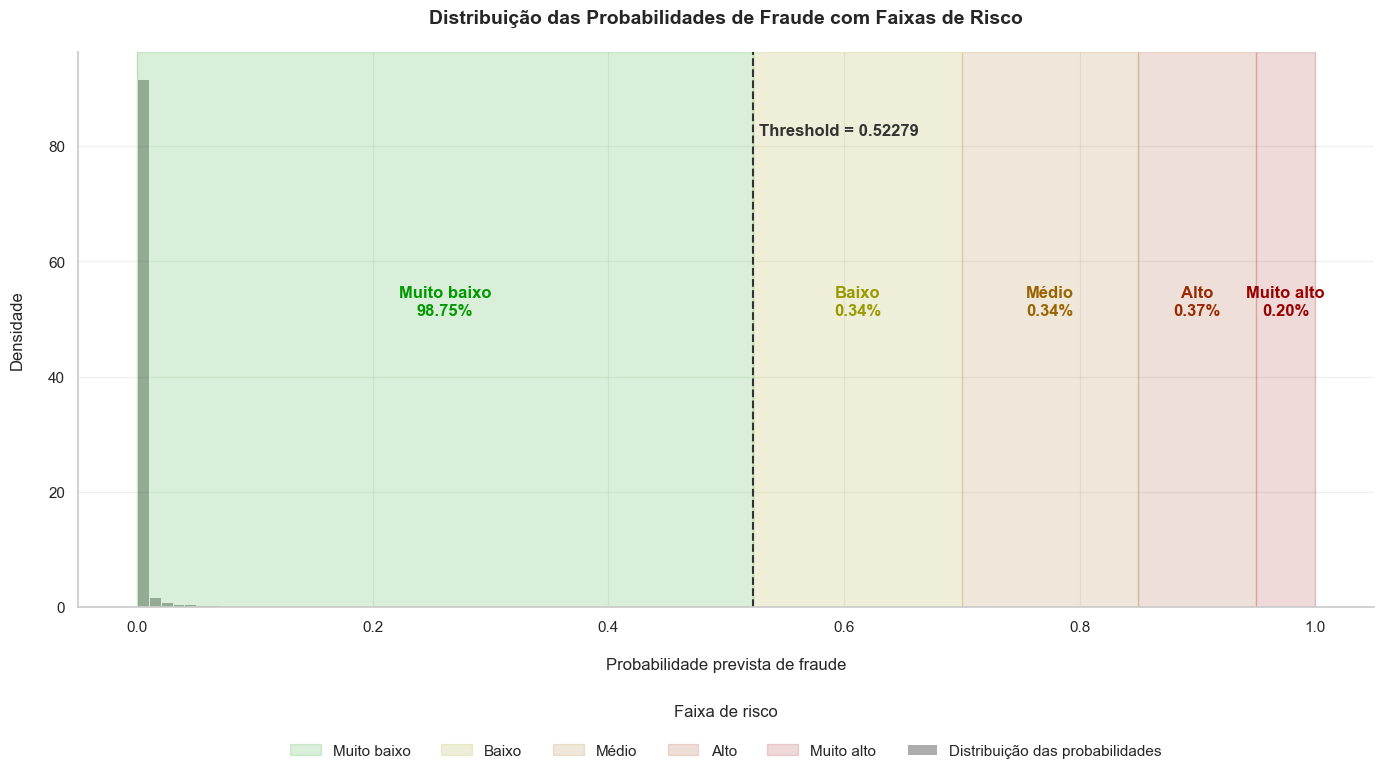

In [182]:
plt.figure(figsize=(14, 8))

# Histograma completo
sns.histplot(df_preds_test['fraud_prob'], bins=100, stat='density',
             color='#333333', label='Distribuição das probabilidades', alpha=0.4)

# Linha do threshold
plt.axvline(x=threshold, color='#333333', linestyle='--', linewidth=1.5)
plt.text(threshold + 0.005, plt.ylim()[1]*0.85, f'Threshold = {threshold:.5f}',
         color='#333333', fontsize=12, fontweight='bold')

# Faixas de risco
faixas_risco = [
    (0.0, threshold, 'Muito baixo', '#009900'),
    (threshold, 0.70, 'Baixo', '#999900'),
    (0.70, 0.85, 'Médio', '#996300'),
    (0.85, 0.95, 'Alto', '#992900'),
    (0.95, 1.0, 'Muito alto', '#990000'),
]

# Adiciona cada faixa de risco com texto do percentual
for start, end, label, color in faixas_risco:
    plt.axvspan(start, end, color=color, alpha=0.15, label=label)
    
    # Posicionamento do texto no meio da faixa
    x_pos = (start + end) / 2
    y_pos = plt.ylim()[1] * 0.55
    
    percent = risk_distribution.get(label, 0.0)
    plt.text(x_pos, y_pos, f'{label}\n{percent:.2f}%', ha='center', va='center',
             fontsize=12, fontweight='bold', color=color)

# Ajustes visuais
plt.title('Distribuição das Probabilidades de Fraude com Faixas de Risco\n', fontsize=14, fontweight='bold')
plt.xlabel('\nProbabilidade prevista de fraude', fontsize=12)
plt.ylabel('Densidade\n', fontsize=12)
plt.legend(title='Faixa de risco\n', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6, frameon=False)
sns.despine()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 5. Análise do modelo e impacto no negócio

Foram processados 2.194.300 registros de transações que **não possuem rótulo** identificando se a operação é ou não uma fraude.

O modelo, ajustado com o algoritmo **XGBoost** e utilizando um **threshold (limiar de decisão)** de 0.52279, previu **27.332 transações como potenciais fraudes**, o que representa aproximadamente **1,25%** do total. Esse percentual, embora superior à taxa real de fraude (\~0,15%) observada nos dados rotulados, reflete um **compromisso mais equilibrado entre recall e precisão**, considerando que o threshold foi otimizado com base nessas métricas.

Dado o **forte desbalanceamento** típico em problemas de fraude (onde a classe positiva é rara), os resultados obtidos podem ser considerados **aceitáveis** em diversos contextos operacionais e de negócio.

Para oferecer **maior nuance nas predições**, as transações com **probabilidade acima do limiar de decisão** foram segmentadas em faixas de risco, variando de *muito baixo* a *muito alto*, conforme a tabela abaixo:

| Faixa de Risco | Intervalo de Probabilidade | Interpretação Operacional          |
| -------------- | -------------------------- | ---------------------------------- |
| Muito alto     | ≥ 0.95                     | Bloquear/inspecionar imediatamente |
| Alto           | 0.85 – 0.95                | Revisar com urgência               |
| Médio          | 0.70 – 0.85                | Revisar conforme capacidade        |
| Baixo          | 0.52279 – 0.70             | Monitorar, sem ação imediata       |
| Muito baixo    | < 0.52279                  | Provavelmente legítimas            |

Com essa segmentação, é possível atender às diretrizes e normas estabelecidas pela **área de negócio** para o tratamento de transações suspeitas. A categorização por faixas permite que a **área operacional** defina ações específicas para cada nível de risco, podendo ir desde o **tratamento automático** até uma **análise manual mais criteriosa**.

No entanto, é importante destacar que, mesmo com um modelo bem ajustado, **transações fraudulentas podem passar despercebidas**, assim como **clientes legítimos podem ser impactados** por falsos positivos. Por isso, é fundamental que as ações baseadas nas predições do modelo sejam **alinhadas entre as áreas de negócio e operações**, considerando o equilíbrio entre **risco aceito, custo operacional e experiência do cliente**.